In [420]:
import numpy as np
import os
from random import shuffle
import re
import urllib.request
import zipfile
import lxml.etree
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import time
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import matplotlib.cm as cm

#plotting
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import RegexpTokenizer

Loading BokehJS ...

# Part 0: Download & tokenize the TED Dataset

### Download the dataset

In [175]:
# Download Dataset
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")
    
    
# Extract documents   
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))

# Build list of english words
wordlist = [w for w in nltk.corpus.words.words('en') if w.islower()]

### Preprocess and store content & keywords
#### Preprocessing steps:

1) Create list of words by splitting on real words. This removes punctuations, parenthesis, etc   
2) Perform stemming. This converts different variations of the same word into one word. Houses and House become House, for example.   
3) Remove stopwords  
4) Convert all to lower case.  

In [176]:
input_list = []
keywords_list = []

# Define function to process Subtitles
def processSubtitles(raw):
    porter = nltk.PorterStemmer()
    
    #tokenize & remove all punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(raw)
    # word stemming
    tokens = [porter.stem(t) for t in tokens]
#     remove stopwords and convert to lowercase
    tokens = [word.lower() for word in tokens if word not in stopwords.words('english')]
    return tokens

# Extract content & preprocess
for document in doc.findall('//content'):
    input_list.append(processSubtitles(document.text))
    
# Extract keywords & 
for x in doc.findall('//keywords'):
    keywords_list.append(x.text.lower())  
    


In [181]:
class_list = []
label_list = []
class_list_onehot = []

for keywords in keywords_list:
    label = [0,0,0]
    labelValue = 0
    if "technology" in keywords :
        label[0] = 1
        labelValue += 4
    if "entertainment" in keywords :
        label[1] = 1
        labelValue +=2 
    if "design" in keywords :
        label[2] = 1
        labelValue += 1
    
    class_list.append(label)
    label_list.append(labelValue)
    
class_list_onehot = np.eye(8)[label_list]    

In [216]:
# print(len(input_list))
# data = {'input_list': input_list, 'keywords_list': keywords_list, 'label_list': label_list, 'class_list_onehot': class_list_onehot}
# with open('processed_talks.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump(data, f)
    
with open('processed_talks.pickle', 'rb') as f:
     data = pickle.load(f)

input_list = data['input_list']
keywords_list = data['keywords_list']
label_list = data['label_list']
class_list_onehot = data['class_list_onehot']

# Part 1: Download GloVe embeddings

### Download & create GloVe dictionary

In [183]:
# import GloVe Wikipedia 2014 + Gigaword 5 pretrained mapping.
with zipfile.ZipFile('glove.6B.zip', 'r') as z:
    doc = (z.open('glove.6B.50d.txt', 'r'))
    
    lines = doc.read().decode('utf-8').splitlines()
    
del doc

In [184]:
# create GloVe dictionary
glove_dict = {}

for e in lines:
    line_list = e.split()
    # extract values and convert to float
    glove_dict[line_list[0]] = list(map(float, line_list[1:]))


In [185]:
# Save glove dictionary
# with open('glove_dict.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump(glove_dict, f)
    
with open('glove_dict.pickle', 'rb') as f:
     glove_dict = pickle.load(f)

### Partition data into sublists with shuffled words from non-OOO Talks

In [225]:
new_input_list = []
new_class_list = []

print(len(input_list))
print(len(label_list))

for (talk,label) in zip(input_list,label_list):
    if label == 0:
        new_input_list.append(talk)
        new_class_list.append(label)
    else:
        # duplicate talk 10 times
        new_input = talk*10
        # shuffle list of duplicate talks
        new_input = shuffle(new_input)
        # split into 10 chunks
        new_input = np.array_split(new_input, 10)
#         new_input = new_input.tolist()
        new_label = [label]*len(new_input)
        #append new_input and new_label to new label and input lists
        new_input_list = new_input_list + new_input
        new_class_list = new_class_list + new_label
        
print("processing done")

2085
2085
processing done


In [229]:
# print(input_list[40])
print(type(input_list))

<class 'list'>


In [230]:
# print(new_input_list[40])
print(type(new_input_list))

<class 'list'>


In [231]:
input_list = new_input_list
class_list_onehot = np.eye(8)[new_class_list]   

### Create Bag-of-means

In [234]:
# create Bag-of-means
# represent each document by a vector: the mean of the words in that document
bag_of_means = []
# words not in the dictionary are represented as a vector of zeros
null_word = 50*[0]

def getGloVe(word):
    if word in glove_dict:
        return np.reshape(glove_dict[word], 50).reshape(1,-1)
    else:
        return np.reshape(null_word,50).reshape(1,-1)

# print(cosine_similarity(getGloVe("man"),getGloVe("ixix"))[0][0])

for talk in input_list:
    if len(talk) == 0:
        bag_of_means.append(np.reshape(null_word,50).reshape(1,-1)[0])
    else:
        bag_of_means.append(np.mean(list(map(getGloVe,talk)),axis=0)[0])   

# add bias term and convert to numpy array
bag_of_means = np.array(bag_of_means)

In [235]:
# Saving the objects:
# print(len(bag_of_means))
# print(len(class_list_onehot))
# data= {'X': bag_of_means, 'Y': class_list_onehot}
# with open('bag_label_extended.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump(data, f)
    
# with open('bag_label_extended', 'rb') as f:
#      data = pickle.load(f)

# bag_of_means = data['X']
# class_list_onehothot = data['Y']

10698
10698


NB: Run the above only once (unless you wish to change the embeddings)!

# Part 2 Build Neural Network

### Part 2.0 Load & partition data

In [237]:
with open('bag_label_extended.pickle', 'rb') as f:
     data = pickle.load(f)


# X = tf.convert_to_tensor(data['X'], dtype=tf.float32)
# y = tf.convert_to_tensor(data['Y'], dtype=tf.float32)

X = np.asarray(data['X'], dtype=np.float32)
y = np.asarray(data['Y'], dtype=np.float32)

validation_size = 250
test_size   = 250
train_size = len(X) - validation_size - test_size
print(train_size)

x_train = X[:train_size]
y_train = y[:train_size]

x_valid = X[train_size:train_size+validation_size]
y_valid = y[train_size:train_size+validation_size]

x_test = X[train_size+validation_size:]
y_test = y[train_size+validation_size:]

# print(type(x_train))
# print(y_train.shape)

10198


### Part 2.1 Build input pipeline

In [131]:
# Input Pipeline Parameters

# BATCH_SIZE = 64
# NUM_EPOCHS = 200
# BATCHING_ITER = 100
# N_CLASSES = 8
# N_FEATURES = 50
# CAP = 100
# MINADEQ = 50

In [132]:
# # Create input queues:

# def create_input_queue(X, Y, NUM_E):
    
#     x_queue, y_queue = tf.train.slice_input_producer(
#                                         [X, Y],
#                                         shuffle=False,
#                                         num_epochs = None
#     )

#     # cast one_hot labels to integer
#     y_queue = tf.cast(y_queue, tf.int32)
#     return x_queue, y_queue
    
# print("Input pipeline ready")

### Part 2.2: Build NN Structure

In [410]:
# Network Parameters
BATCH_SIZE = 100
NUM_EPOCHS = 500
BATCHING_ITER = 50

N_CLASSES = 8
N_FEATURES = 50
LEARNING_RATE = 0.001
N_LAYERS = 3
LAYER1_SIZE = 20
LAYER2_SIZE = 40
LAYER3_SIZE = 20
N_INPUT = BATCH_SIZE
OPTIMIZER_ADAM = 0

# Network Placeholders

x_ = tf.placeholder(tf.float32, [None, N_FEATURES])
y_ = tf.placeholder(tf.float32, [None, N_CLASSES])

In [411]:
# Create weights and biases
if N_LAYERS == 3:
    weights = {

        'h1': tf.Variable(tf.random_normal([N_FEATURES, LAYER1_SIZE])),
        'h2': tf.Variable(tf.random_normal([LAYER1_SIZE, LAYER2_SIZE])),
        'h3': tf.Variable(tf.random_normal([LAYER2_SIZE, LAYER3_SIZE])),
        'out': tf.Variable(tf.random_normal([LAYER3_SIZE, N_CLASSES]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([LAYER1_SIZE])),
        'b2': tf.Variable(tf.random_normal([LAYER2_SIZE])),
        'b3': tf.Variable(tf.random_normal([LAYER3_SIZE])),
        'out': tf.Variable(tf.random_normal([N_CLASSES]))
    }
elif N_LAYERS == 2:
    weights = {

        'h1': tf.Variable(tf.random_normal([N_FEATURES, LAYER1_SIZE])),
        'h2': tf.Variable(tf.random_normal([LAYER1_SIZE, LAYER2_SIZE])),
        'out': tf.Variable(tf.random_normal([LAYER2_SIZE, N_CLASSES]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([LAYER1_SIZE])),
        'b2': tf.Variable(tf.random_normal([LAYER2_SIZE])),
        'out': tf.Variable(tf.random_normal([N_CLASSES]))
    }
else:
    weights = {

        'h1': tf.Variable(tf.random_normal([N_FEATURES, LAYER1_SIZE])),
        'out': tf.Variable(tf.random_normal([LAYER1_SIZE, N_CLASSES]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([LAYER1_SIZE])),
        'out': tf.Variable(tf.random_normal([N_CLASSES]))
    }

In [413]:
# Define NN structure

# layer 1
Wx = tf.matmul(x_, weights['h1'])
h = tf.nn.relu(tf.add(Wx, biases['b1']))

# layer 2 (Optional): enable by setting N_LAYERS=2
if N_LAYERS > 1:
    Wx = tf.matmul(h, weights['h2'])
    h = tf.nn.relu(tf.add(Wx, biases['b2']))
    
if N_LAYERS > 2:
    Wx = tf.matmul(h, weights['h3'])
    h = tf.nn.relu(tf.add(Wx, biases['b3']))
    
# output layer
u = tf.matmul(h,weights['out']) + biases['out']

In [414]:
# Define NN Ops

# create Op for loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=u, labels=y_))

# create Op for optimizer
if OPTIMIZER_ADAM == 1:
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)
else:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

# save predicted and true labels
printTrueLabel = tf.argmax(y_, 1)
printPredLabel = tf.argmax(u, 1)

# create Op for accuracy
correct_prediction = tf.equal(tf.argmax(u, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# create Op to initialize all variables
init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())

In [415]:
# Output Variables
train_accuracy = []
valid_accuracy = []
y_out_pred = []
y_out_true = []


with tf.Session() as sess:
    #initialize vairables and queue
    sess.run(init_op)

    for epoch in range(NUM_EPOCHS):
        # shuffle training data
        
        for batch in range(BATCHING_ITER):
            x_batch, y_batch = shuffle(x_train, y_train, n_samples=BATCH_SIZE, random_state=batch)
            _, c = sess.run([optimizer, cost], feed_dict={x_: x_batch, y_: y_batch})
        
        # Evaluate accuracy at each epoch
        train_accuracy.append(accuracy.eval({x_: x_train, y_: y_train}))
        valid_accuracy.append(accuracy.eval({x_: x_valid, y_: y_valid}))
    
    V = sess.run(weights["out"])
    sess.close()
print(len(train_accuracy))

def runTest():
    test_accuracy = accuracy.eval({x_: x_test, y_: y_test})
    return test_accuracy

# best results:
# BATCH_SIZE = 100
# NUM_EPOCHS = 500
# BATCHING_ITER = 100

# N_CLASSES = 8
# N_FEATURES = 50
# LEARNING_RATE = 0.001
# N_LAYERS = 2
# LAYER1_SIZE = 25
# LAYER2_SIZE = 15
# LAYER3_SIZE = 15
# N_INPUT = BATCH_SIZE
# OPTIMIZER_ADAM = 0

500


### Training with train data extended

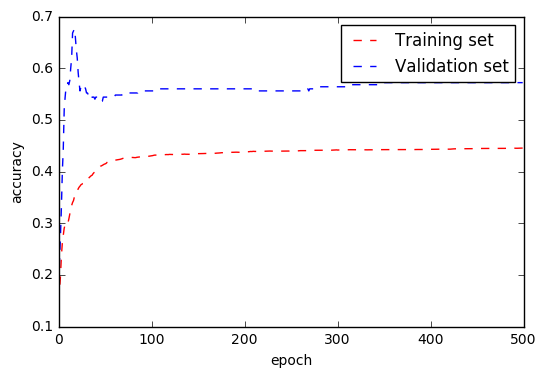

In [418]:
# extended data set + preprocessing
t=list(range(0,NUM_EPOCHS))
plt.plot(t, train_accuracy, 'r--',t,valid_accuracy, 'b--')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Training set", "Validation set","Test set"])
plt.show()

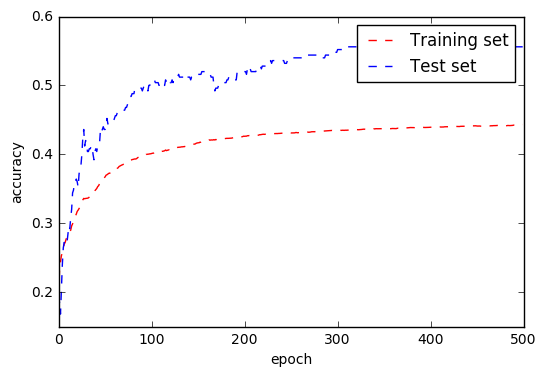

In [419]:
train_valid_accuracy = []
test_accuracy = []

x_train = np.concatenate((x_train,x_valid),axis=0)
y_train = np.concatenate((y_train, y_valid),axis=0)
# Train model on Training + validation data
with tf.Session() as sess:
    #initialize vairables and queue
    sess.run(init_op)

    for epoch in range(NUM_EPOCHS):
        # shuffle training data
        
        for batch in range(BATCHING_ITER):
            x_batch, y_batch = shuffle(x_train, y_train, n_samples=BATCH_SIZE, random_state=batch)
            _, c = sess.run([optimizer, cost], feed_dict={x_: x_batch, y_: y_batch})
        
        # Evaluate accuracy at each epoch
        train_valid_accuracy.append(accuracy.eval({x_: x_train, y_: y_train}))
        test_accuracy.append(accuracy.eval({x_: x_test, y_: y_test}))
    
    V = sess.run(weights["out"])
    sess.close()
    
# extended data set + preprocessing
t=list(range(0,NUM_EPOCHS))
plt.plot(t, train_valid_accuracy, 'r--',t,test_accuracy, 'b--')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Training set","Test set"])
plt.show()

### Text preprocessing, no train extension

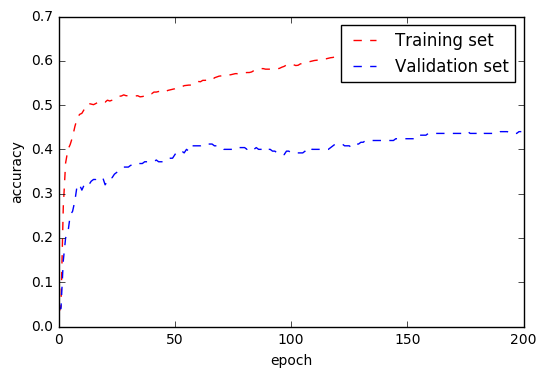

In [138]:
# Stemming & Remove Stopwords: No extension
t=list(range(0,NUM_EPOCHS))
plt.plot(t, train_accuracy, 'r--',t,valid_accuracy, 'b--')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Training set", "Validation set","Test set"])
plt.show()

#### No stemming

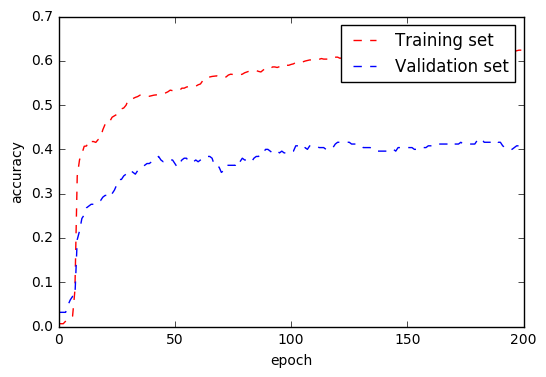

In [129]:
t=list(range(0,NUM_EPOCHS))
plt.plot(t, train_accuracy, 'r--',t,valid_accuracy, 'b--')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Training set", "Validation set","Test set"])
plt.show()

### Viewing output projection of last NN (train set extension & text preprocessing)

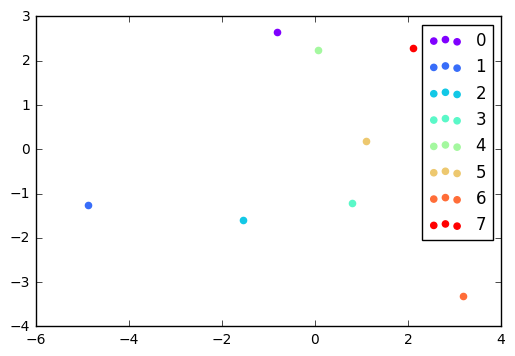

In [421]:
pca = PCA(n_components=2)
proj = pca.fit_transform(V.transpose())

colors = cm.rainbow(np.linspace(0, 1, len(proj)))
for y, c in zip(proj, colors):
    plt.scatter(y[0], y[1], color=c)
    
plt.legend([0,1,2,3,4,5,6,7])
plt.show()

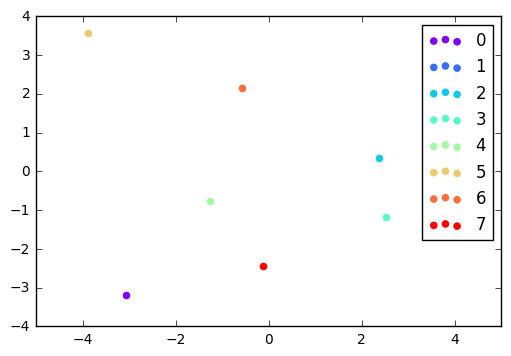

In [90]:
pca = PCA(n_components=2)
proj = pca.fit_transform(V.transpose())

colors = cm.rainbow(np.linspace(0, 1, len(proj)))
for y, c in zip(proj, colors):
    plt.scatter(y[0], y[1], color=c)
    
plt.legend([0,1,2,3,4,5,6,7])
plt.show()